# Preprocesamiento de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [235]:
df_train = pd.read_csv('data/train.csv')

### Un poco de preproceso

Antes de empezar a analizar los datos, vamos a realizar algunos procesos previos y obtener algunas variables que nos van a ser útiles más adelane:

- Lista de las columnas numéricas (dividida por tipos de acuerdo a lo que miden)
- Lista de las variables categóricas (dividida por tipos de acuerdo a lo que miden)
- Lista de variables ordinales (dividida por tipos de acuerdo a lo que miden)

También vamos a reemplazar algunos `NA` por un valor más significativo ya que muchos de estos se refieren en realidad a que no existe cierta condición y no a que haya un dato faltante

In [191]:
#1. Convertimos valores faltantes en "No" para expresar realmente lo que quieren decir
meaningfulNA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
df_train[meaningfulNA] = df_train[meaningfulNA].fillna('No')

#2. Obtenemos una lista de las variables numéricas y contínuas, para esto hay que quitar las variables que son ordinales 
# y ya están codificadas como números. En el camino vamos a hacer una lista de las variables que tienen que ver condiciones de calidad 
# (ordinales) pero no codificadas como números y también una lista de variables categóricas

qualCon = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 
           'PoolQC', 'BsmtQual', 'BsmtCond', 'OverallQual', 'OverallCond']
# Esta es una clasificación con código numérico pero que no representa una variable ordinal
compl = ['MSSubClass']
cat = df_train.select_dtypes(include=['object']).columns.tolist()
cat = set(cat).difference(qualCon + compl)
num = df_train.select_dtypes(exclude=['object']).columns
num = set(num).difference(qualCon + compl)

# Listas de variables por "cosa" que miden y tipo de dato

# Numéricas
total = ['LowQualFinSF'] # se refiere al total de la casa
floor = ['TotalBsmtSF', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF']
room = ['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']
rest = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath']
bsmt = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
area = ['GrLivArea', 'LotArea', 'LotFrontage']
garage = ['GarageArea', 'GarageCars', 'GarageYrBlt']
outRoom = ['Fireplaces', 'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
total_num = total + floor + room + rest + bsmt + area + garage + outRoom 
# Fechas
season = ['YearRemodAdd', 'GarageYrBlt', 'YearBuilt']
season2 = ['MoSold', 'YrSold']
#Catgóricas
total2 = ['MSSubClass','MSZoning','BldgType','Foundation','HouseStyle']
material = ['RoofStyle', 'RoofMatl',  'MasVnrType', 'Electrical','Exterior1st', 'Exterior2nd']
bsmt2 = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
area2 = ['LotShape','LotConfig']
garage2 = ['GarageType', 'GarageFinish'] 
outRoom2 = ['Heating', 'CentralAir','Fence', 'MiscFeature']
town2 = ['Neighborhood','LandContour','LandSlope','Condition1', 'Condition2']
system2 = ['Street', 'Alley','PavedDrive',  'Utilities','Functional', 'SaleType', 'SaleCondition']
total_categoricas = total2 + material + bsmt2 + area2 + garage2 + outRoom2 + town2 + system2
#Ordinales
total3 = ['OverallQual', 'OverallCond', 'MSSubClass']
material3 = [ 'ExterQual', 'ExterCond']
bsmt3 = ['BsmtQual', 'BsmtCond']
room3 = ['KitchenQual']
garage3 = ['GarageQual', 'GarageCond']
outRoom3 = ['FireplaceQu','HeatingQC', 'PoolQC']
ordVar = total3+material3+bsmt3 + room3 + garage3 + outRoom3


Estas listas nos pueden ayudar a diferentes etapas del proceso, por ejemplo para tratar de forma diferente las variables de acuerdo a su tipo y propósito.

### SalePrice

Lo primero es ver que tal se porta la variable objetivo. Ver su distribución y examinar qué tanto se parece a una normal ¿por qué es importante?

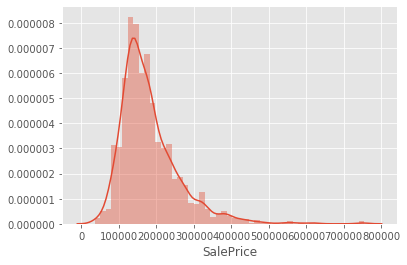

In [192]:
sns.distplot(df_train['SalePrice'])

Pues no parece una distribución normal. Lo podemos comprobar visualmente usando un qqplot 

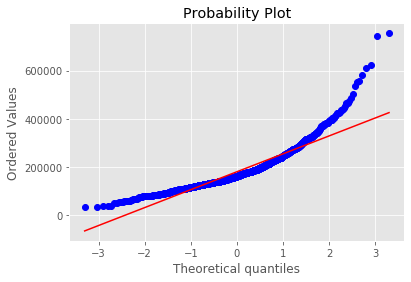

In [193]:
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Aquí es mucho más claro que la distribución no es normal. Está sesgada a la derecha. En estos casos, hay una solución muy fácil, transformar usando el logaritmo.

¿Por qué funciona eso?

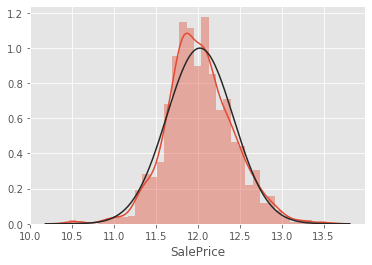

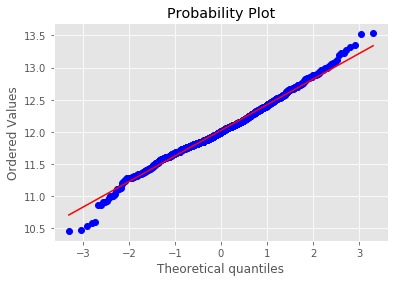

In [194]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Mucho mejor!!!!

Ahora, esto puede pasar con todas las variables numéricas, entonces vamos a observar las distribuciones de aquellas variables que estén demasiado sesgadas o tengan demasiada kurtosis.

Es importante distinguir los casos en los que las distribuciones incluyen o no ceros!!!

In [195]:
overSkew = df_train.loc[:,num].columns[df_train.loc[:,num].skew() > 2.5].values
overKurt = df_train.loc[:,num].columns[df_train.loc[:,num].kurt() > 2.5].values
lowKurt = df_train.loc[:,num].columns[df_train.loc[:,num].kurt() < -2.5].values
if not overSkew.size: print('overSkew: ' ,overSkew) 
else:print('Tenemos variables sesgadas')
if not overKurt.size: print('overKurt: ' ,overKurt) 
else: print('Tenemos variables con alta kurtosis')
if not lowKurt.size: print('lowKurt is None + No uniform distribution in Data Sets')
else: print('Tenemos variables con baja kurtosis')

overDist = set(overSkew).union(set(overKurt)).union(set(lowKurt))
modNum = set(num) - overDist
zeroNum = df_train.loc[:, overDist].columns[(df_train.loc[:, overDist] == 0).sum() > 100]
overDistN0 = overDist - set(zeroNum)
overDist0 = set(zeroNum)
#print(list(zeroNum))
print('Variables distorsionadas (sin ceros) ', overDistN0)
print('Variables distorsionadas (con muchos ceros) ',overDist0)

Tenemos variables sesgadas
Tenemos variables con alta kurtosis
lowKurt is None + No uniform distribution in Data Sets
Variables distorsionadas (sin ceros)  {'GrLivArea', 'KitchenAbvGr', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'LotFrontage'}
Variables distorsionadas (con muchos ceros)  {'LowQualFinSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtHalfBath', 'MiscVal', 'BsmtFinSF2', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'EnclosedPorch', 'MasVnrArea'}


Grafiquemos las distribuciones y veamos los valores de su sesgo y kurtosis

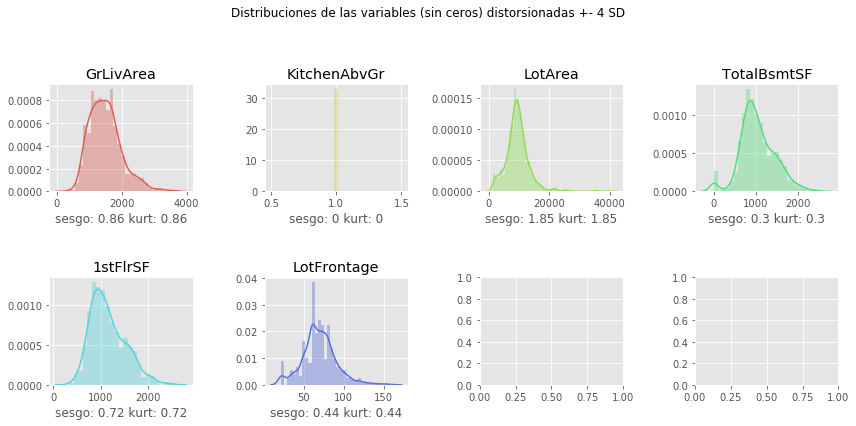

In [196]:
tmp_train = df_train.loc[:,overDistN0].dropna()
def reject_outliers(data, m=4):
    # con esta función quitamos outliers (por default lejanos 4 veces de la std) para que no molesten en las gráficas
    return data[abs(data - np.mean(data)) < m * np.std(data)]
f, axes = plt.subplots(2, 4, figsize = (12, 6), sharey = False)
colors = sns.color_palette("hls", 8)
for ix, var in enumerate(tmp_train.columns):
    row, col = divmod(ix, 4)
    tmpVar = reject_outliers(tmp_train[var])
    var_label = 'sesgo: ' + str(round(tmpVar.skew(),2)) + ' kurt: ' + str(round(tmpVar.skew(),2))
    axes[row,col] = sns.distplot(tmpVar,kde = True, ax = axes[row, col], color =colors[ix])
    axes[row, col].set_title(var)
    axes[row, col].set_xlabel(var_label)
plt.suptitle('Distribuciones de las variables (sin ceros) distorsionadas +- 4 SD', fontsize = 12)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.8, top = 0.8)
plt.show()
#print(df_train.loc[:,overDistN0].apply(reject_outliers).dropna().apply(lambda x: pd.Series({'kurt': kurtosis(x), 'skew' : skew(x)})).T)
del tmp_train


En realidad, la única que realmente presaenta problemas serios es `LotArea`. Vemos qué transformación funciona mejor a corrijamos sus valores

In [197]:
# Tres transformaciones diferentes para corregir las distorsiones
logLot = np.log1p(df_train['LotArea']).kurt()
rootLot = np.sqrt(df_train['LotArea']).kurt()
cubicLot = np.power(df_train['LotArea'],2).kurt()

# Probamos cual corrige mejor
minVal = min([logLot, rootLot, cubicLot])
if logLot == minVal:
    best = 'log'
    df_train['LotArea'] = np.log1p(df_train['LotArea'])
elif rootLot == minVal:
    best = 'root'
    df_train['LotArea'] = np.sqrt(df_train['LotArea'])
elif cubicLot == minVal:
    best = 'cubic'
    df_train['LotArea'] = np.power(df_train['LotArea'],2)
print('La mejor transformación es ' + best)

La mejor transformación es log


Aplicamos el mismo proceso para las variables con muchos ceros (¿qué es lo diferente?)

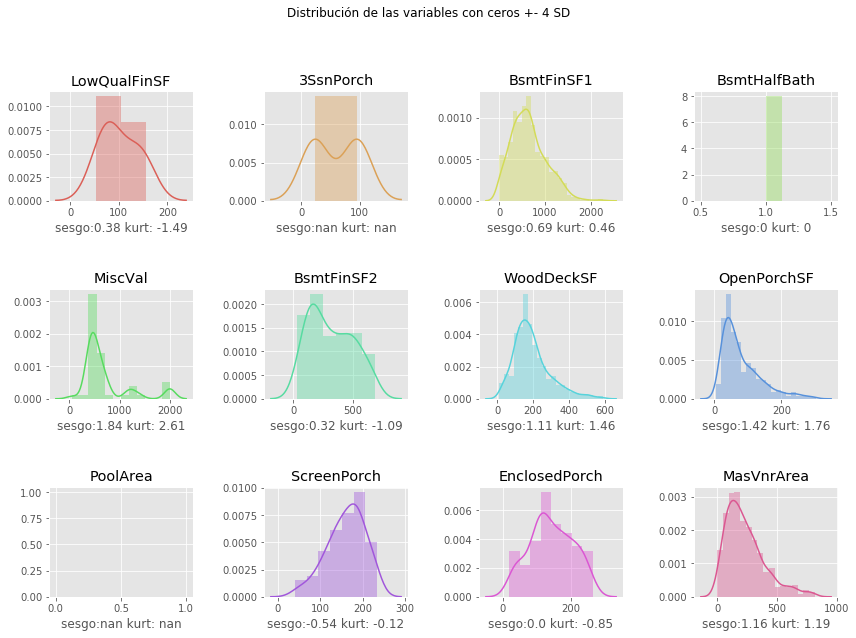

In [198]:
tmp_train = df_train.loc[:,overDist0].dropna()
def reject_outliers2(data, m=4):
    data = data[abs(data - np.mean(data)) < m * np.std(data)]
    return data.loc[data != 0]
f, axes = plt.subplots(3, 4, figsize = (12, 9), sharey = False)
colors = sns.color_palette("hls", 12)
dataF = dict()
for ix, var in enumerate(tmp_train.columns):
    row, col = divmod(ix, 4)
    tmpVar = reject_outliers2(tmp_train[var])
    var_label = 'sesgo:'+ str(round(tmpVar.skew(),2)) + ' kurt: ' + str(round(tmpVar.kurt(),2))
    sns.distplot(tmpVar,kde = True, ax = axes[row, col], color =colors[ix])
    axes[row,col].set_title(var)
    axes[row,col].set_xlabel(var_label)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.8, top = 0.85)
plt.suptitle('Distribución de las variables con ceros +- 4 SD', fontsize = 12)
plt.show()

del tmp_train

Aquí no se ven problemas graves entonces podemos seguir adelante

### Explorando las relaciones entre variables

Primero vamos a ver cómo se relacionan las variables numéricas con nuestro objetivo. Primero vamos a explorar la matriz de correlaciones para las variables numéricas sin ceros



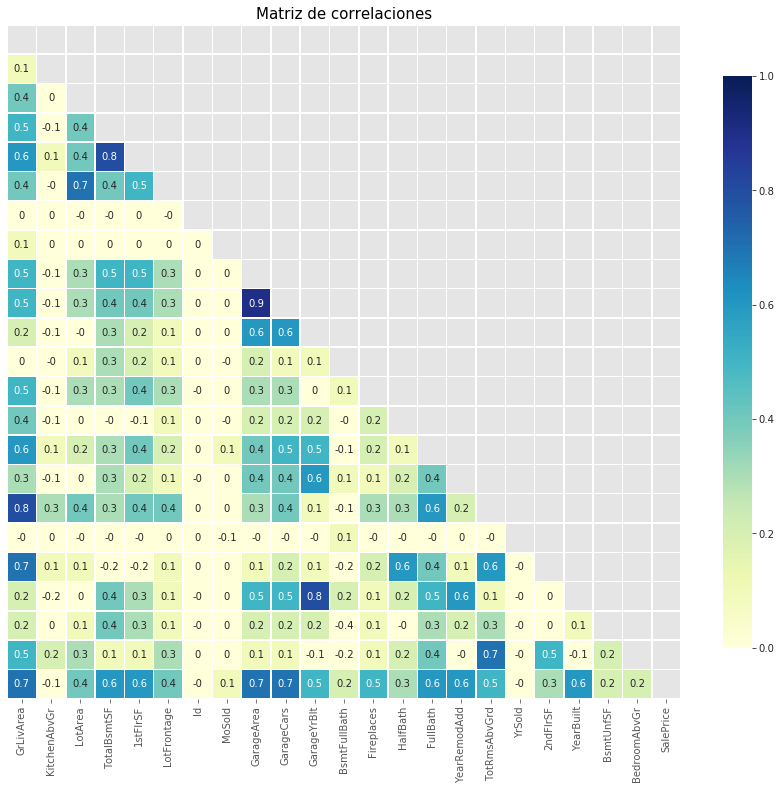

In [199]:
num_none_zero = list(overDistN0) + list(modNum)
for ix, x in enumerate(num_none_zero):
    if x == 'SalePrice':
        salePos = ix
        break
num_none_zero[salePos], num_none_zero[len(num_none_zero) - 1] = num_none_zero[len(num_none_zero) - 1], num_none_zero[salePos]

numCorr = df_train.loc[:,num_none_zero].corr().round(1)

f, ax = plt.subplots(1,1, figsize = (12, 12))
mask = np.zeros_like(numCorr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(numCorr, annot = True, mask=mask, vmin =0, square=True, linewidths = .5, cmap="YlGnBu", ax = ax,
               cbar_kws = {'shrink' : 0.7})
    ax.set_yticks([])
    bottom, top = ax.get_ylim() ## Estas dos líneas son para corregir un bug en seaborn
    ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Matriz de correlaciones", fontsize = 15)
plt.tight_layout()
plt.show()

Las variables de Kitchen, Bedroom y Bath (excepto FullBath) muestran muy poca relación con nuestro objetivo, entonces las vamos a quitar del dataframe

In [200]:
dropNoCorr = ['BsmtFullBath', 'BsmtHalfBath','HalfBath', 'FullBath', 'KitchenAbvGr', 'GarageYrBlt']
df_train.drop(dropNoCorr, axis=1, inplace=True)

Y también hay que quitarlas de las listas de variables correspondientes

In [201]:
rest = [r for r in rest if r not in ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']]
room.remove('KitchenAbvGr')
garage.remove('GarageYrBlt')
total_num = [t for t in total_num if t not in dropNoCorr]

### Valores faltantes

Tenemos valores faltantes en varias columnas, algo tenemos que hacer con ellos. El primer paso desde luego es ver en qué columnas y qué proporción.

In [202]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
LotFrontage,259,0.177397
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
ExterQual,0,0.000000
RoofStyle,0,0.000000
RoofMatl,0,0.000000
Exterior1st,0,0.000000
Exterior2nd,0,0.000000


Aquí tenemos tres opciones para remediar los valores perdidos:

- Eliminar los registros
- Eliminar las columnas
- Imputar las variables

Para el caso del valor faltante en `Electrical` lo mejor es eliminar el registro, es sólo uno y por lo tanto no vamos a perder mucha información, para los casos de `MasVnrType` y  `MasVnrArea` de alguna forma estamos en el límite, entonces vale la pena investigar un poco más, por ejemplo, en ambos casos hay 8 registros faltantes ¿son los mismos?

In [203]:
df_train[df_train['MasVnrType'].isnull()]['MasVnrArea']

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

Ok, entonces los registros que tienen faltante en uno, tienen también faltante en el otro. `MasVnrType` es categórica, pero `MasVnrArea` es numérica, investiguemos entonces su correlación con el objetivo y las demás variables:

In [204]:
df_train.corr()['MasVnrArea']

Id              -0.050298
MSSubClass       0.022936
LotFrontage      0.193458
LotArea          0.123717
OverallQual      0.411876
OverallCond     -0.128101
YearBuilt        0.315707
YearRemodAdd     0.179618
MasVnrArea       1.000000
BsmtFinSF1       0.264736
BsmtFinSF2      -0.072319
BsmtUnfSF        0.114442
TotalBsmtSF      0.363936
1stFlrSF         0.344501
2ndFlrSF         0.174561
LowQualFinSF    -0.069071
GrLivArea        0.390857
BedroomAbvGr     0.102821
TotRmsAbvGrd     0.280682
Fireplaces       0.249070
GarageCars       0.364204
GarageArea       0.373066
WoodDeckSF       0.159718
OpenPorchSF      0.125703
EnclosedPorch   -0.110204
3SsnPorch        0.018796
ScreenPorch      0.061466
PoolArea         0.011723
MiscVal         -0.029815
MoSold          -0.005965
YrSold          -0.008201
SalePrice        0.430809
Name: MasVnrArea, dtype: float64

Pues tiene una correlación decente con el objetivo ($0.43$) y no pareces ser demasiado redundante con ninguna otra variable, entonces creo que lo más conveniente es imputarla. Vamos a suponer que los valores faltantes suceden complétamente al azar, es decir, que no depende de otras variables, en este caso, podemos imputar con una regresión basada en las demás variables

In [205]:
from sklearn import linear_model
# Seleccioné tres variables para la regresión de forma un poco arbitraria, basado en las correlaciones
dfImpute = df_train.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea', 'MasVnrArea']].copy()
testIx = dfImpute.loc[:,'MasVnrArea'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']], dfTrain.loc[:, 'MasVnrArea'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']])
# Asigno los valores calculados
df_train.loc[testIx,'MasVnrArea'] = lrImpute

# vuelvo a ver los fltantes para ver que todo vaya bien
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
ExterQual,0,0.000000


Bien, ya corregimos `MasVnrArea`, vamos a proceder exáctamente de la misma forma para `LotFrontage`

In [206]:
# Seleccioné otras tres variables de la misma forma que en la anterior
dfImpute = df_train.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea','LotFrontage']].copy()
testIx = dfImpute.loc[:,'LotFrontage'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']], dfTrain.loc[:, 'LotFrontage'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']])
# Asigno los valores calculados
df_train.loc[testIx,'LotFrontage'] = lrImpute

# vuelvo a ver los fltantes para ver que todo vaya bien
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
ExterQual,0,0.000000
YearRemodAdd,0,0.000000


Para el caso de `Electrical`, como sólo tenemos un registro faltante, lo mejor es eliminar el renglón 

In [207]:
df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index, inplace=True)

Ya sólo nos queda el caso de `MasVnrType` que es más complicado porque es categórica. Vamos a ver qué tanta influencia tiene sobre el objetivo. 

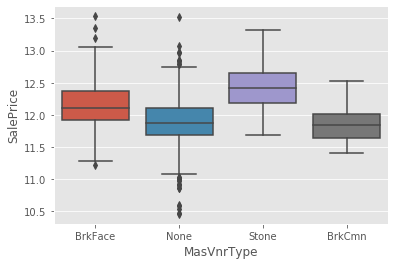

In [208]:
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = df_train)

La verdad es que hay muy poca variación del objetivo, entonces podemos eliminar la variable sin ningun problema.

In [209]:
df_train.drop(['MasVnrType'], axis=1, inplace=True)

Y una vez más, quitarla de las listas correspondientes

In [210]:
material.remove('MasVnrType')
total_categoricas.remove('MasVnrType')

Entonces, ahora sí ya no tenemos datos faltantes por ningún lado ¿verdad?

In [211]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
SalePrice,0,0.0
OverallCond,0,0.0
YearRemodAdd,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0


### Outliers

Ahora ya tenemos limpio nuestro dataset, pero todavía podemos tener problemas con los outliers. Como estamos haciendo una regresión, los valores extremos pueden ser problemáticos porque _jalan_ los promedios, entonces necesitamos identificarlos y eliminarlos.

En principio podemos pensar que hay dos tipos diferentes de outliers: univariados y multivariados, los outliers univariados son valores que se alejan mucho de _su_ propia distribución, mientras que los multivariados se alejan de las distribuciones _conjuntas_.

El proceso que vamos a seguir para identificar outliers en las variables continuas es asi:

- Primero vamos a encontrar _candidatos_ a outliers basados en las distribuciones univariadas
- Vamos a ver las distribuciones conjuntas entre las variables y el objetivo
- A partir de eso encontraremos observaciones candidatas a ser eliminadas de la muestra

Empecemos con los outliers univariados, para eso vamos a identificar las observaciones que se separen mas de 4 desviaciones estándar en sus distribuciones. Eso lo vamos a hacer con la función `checkOutlier` que definimos a continuación, también vamos a definir una función auxiliar `outlierCounter` para llevar registro de los candidatos. En esta función vamos a registrar el índice y las variables en las que ese índice aparece como outlier

In [212]:
def checkOutlier(df, m = 4):
    """rrecibe un dataframe con sólo las variables de intervalo"""
    uniOutlier = dict().fromkeys(df.columns, None)
    outSample = abs(df - df.mean()) > 4 * df.std()
    outSum = (abs(df - df.mean()) > 4 * df.std()).sum()
    for key in uniOutlier.keys():
        uniOutlier[key] = set(outSample.index[outSample.loc[:, key]])
    outportion = outSum / df.shape[0]
    print("No contienen ouliers: " ,outSum.index[outportion == 0].tolist())
    outportion = outportion[outportion != 0].sort_values()
    outlierLst = outportion.index.tolist()
    return uniOutlier, outlierLst

from collections import Counter
from collections import defaultdict
def outlierCounter(outlierDict, exceptionLst = ['SalePrice']):
    inter = Counter()
    name = defaultdict(list)
    coreKey = set(outlierDict.keys()).difference(exceptionLst)
    for key in coreKey:
        value = outlierDict[key]
        for val in value:
            inter[val] += 1
            name[val].append(key)
    res = pd.DataFrame([inter, name], index = ['count', 'variable']).T
    res = res.sort_values('count', ascending = False)
    return res

In [213]:
# corremos la función para marcar candidatos
uniOutlier, outlierList = checkOutlier(df_train.loc[:, num_none_zero])

No contienen ouliers:  ['KitchenAbvGr', 'Id', 'MoSold', 'GarageCars', 'GarageYrBlt', 'BsmtFullBath', 'Fireplaces', 'HalfBath', 'FullBath', 'YearRemodAdd', 'YrSold', '2ndFlrSF', 'YearBuilt', 'SalePrice']


In [214]:
outliersUnivariados = outlierCounter(uniOutlier, ['KitchenAbvGr','SalePrice'])
outliersUnivariados

,count,variable
1298,5,"[GrLivArea, 1stFlrSF, GarageArea, TotalBsmtSF,..."
523,3,"[GrLivArea, 1stFlrSF, TotalBsmtSF]"
496,2,"[1stFlrSF, TotalBsmtSF]"
635,2,"[TotRmsAbvGrd, BedroomAbvGr]"
313,1,[LotArea]
231,1,[LotFrontage]
1127,1,[LotFrontage]
934,1,[LotFrontage]
197,1,[LotFrontage]
224,1,[BsmtUnfSF]


Ahora vamos a ver los outliers bivariados analizando la distribución conjunta de cada variable contra el objetivo. Para esto simplemente vamos a asignar valores dependiendo del orden. Aquí vamos a marcar como otliers a los que salgan del rango de 4 veces la desviación estándar al 0.9994% de confianza. Entonces, vamos a hacer una función que los identifiqe y al mismo tiempo grafique las distribuciones bivariadas contra la normal (bivariada) que vamos a usar para seleccionar

In [215]:
from scipy.stats import multivariate_normal
def bivarCI(dfNum, y = 'SalePrice', outer = 10, z_score = 0.00006, cols = 2):
    """Toma el dataframe con variables de intervalos y las grafica contra el objetivo.
       Regresa la lista de candidatos
    """
    colNum = dfNum.shape[1]
    row, col = divmod(colNum-1, cols)
    if row == 1 and col == 0: row += 1
    if col != 0: row += 1
    
    
    z_under = z_score * 0.98
    z_upper = z_score * 1.02
    #print(dfNum.columns)
    biOutlier = dict().fromkeys(dfNum.columns, None)
    f, axes = plt.subplots(row, cols, figsize = (4*cols, 4*row))
    f.suptitle('Bivaraite CI', fontsize = 12)
    for ix, var1 in enumerate(dfNum.columns):
        if var1 == y: 
            pass
        else:
            r,c = divmod(ix-1, cols)
            dfPart = dfNum[[var1,y]]
            #dfPart = dfNum.loc[:,[var1,y]]
            dfPart = dfPart[~dfPart.isnull()].copy()
            mask = dfPart.loc[:, var1] != 0
            dfPart = dfPart.loc[mask != 0,:]
            dfPart = (dfPart - dfPart.mean()) / dfPart.std()
            F, X, Y, posProb = bivarConverter(dfPart, outer, z_under, z_upper, N = 700)
            axes[r,c].scatter(dfPart.loc[:, var1], dfPart.loc[:, y], alpha = 1)
            axes[r,c].set_title('Bivaraite CI ' + var1)
            axes[r,c].contourf(X, Y, posProb, alpha=0.5)
            dfPartProb = F.pdf(dfPart.values)
            outIndex = dfPart.index[dfPartProb < z_score]
            biOutlier[var1] = set(outIndex.tolist())
    f.tight_layout(rect = [0, 0.03, 1, 0.95])
    plt.show()
    
    return biOutlier

def bivarConverter(df, outer, z_under, z_upper, N = 500):
    """Genera la gráfica (en realidad la proyección) de la normal bivariada"""
    x_init, y_init = df.min() - outer
    x_end, y_end = df.max() + outer
    X = np.linspace(x_init, x_end, N)
    Y = np.linspace(y_init, y_end, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:,:,0] = X
    pos[:,:,1] = Y
    F = multivariate_normal(mean=df.mean().values, cov=df.corr().values)
    posProb = F.pdf(pos)
    posProb[(z_under < posProb) & (posProb < z_upper)] = 1
    posProb[(z_under > posProb) | (posProb < z_upper)] = 0
    
    
    return F , X, Y, posProb

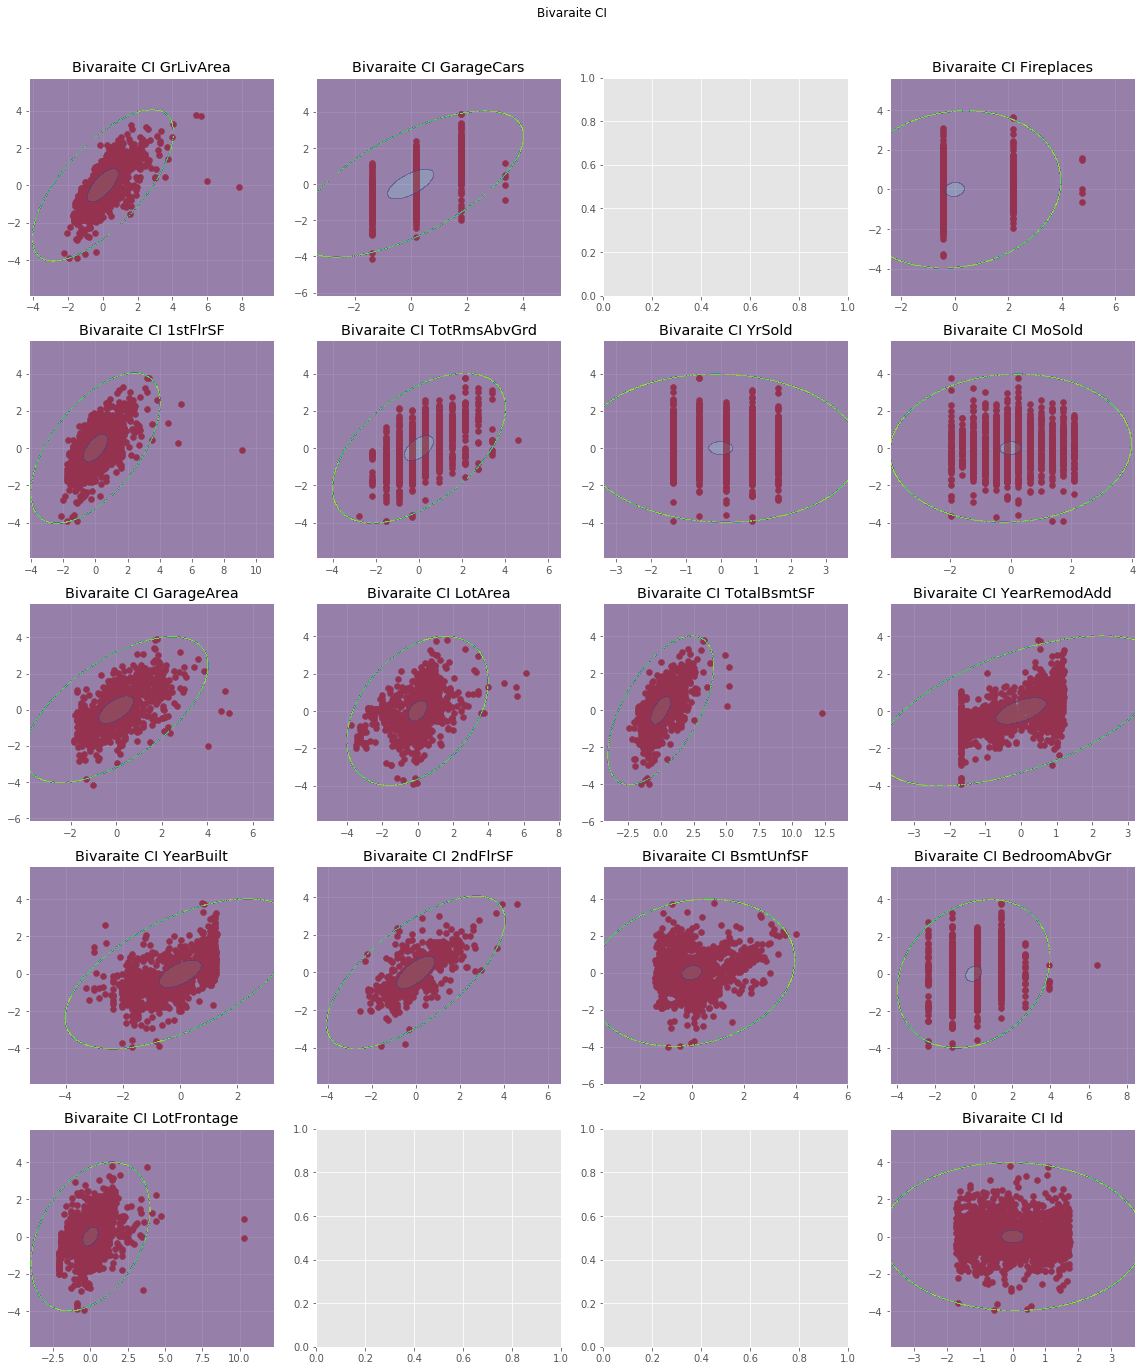

In [216]:
variables = set(num_none_zero).difference(dropNoCorr) # las que quedan vivas
biOutlier = bivarCI(df_train.loc[:,variables], outer = 2, z_score = 0.00006,  cols = 4)

Fireplaces, YrSold e Id (perdón, aquí no debería venir esa variable ¿verdad?) no corresponden a distribuciones normales bivariadas, entonces etiquetemos los outliers sin esas

In [217]:
outliersBivariados = outlierCounter(biOutlier, ['YrSold', 'SalePrice', 'Id'])
outliersBivariados

,count,variable
916,8,"[GarageCars, MoSold, GarageArea, LotArea, Tota..."
1298,8,"[GrLivArea, Fireplaces, 1stFlrSF, TotRmsAbvGrd..."
495,7,"[GrLivArea, 1stFlrSF, MoSold, LotArea, TotalBs..."
1182,7,"[GrLivArea, Fireplaces, YearRemodAdd, YearBuil..."
691,6,"[GrLivArea, Fireplaces, MoSold, YearRemodAdd, ..."
30,5,"[GrLivArea, GarageCars, TotRmsAbvGrd, GarageAr..."
968,3,"[GrLivArea, TotRmsAbvGrd, 2ndFlrSF]"
523,3,"[GrLivArea, 1stFlrSF, TotalBsmtSF]"
304,3,"[GrLivArea, YearBuilt, 2ndFlrSF]"
635,3,"[GrLivArea, TotRmsAbvGrd, BedroomAbvGr]"


Intersectemos ahora las dos listas para definir mejor los candidatos 

In [218]:
def mergeTwoOut(uni, bi, cutoff = 1):
    """Regresa un dataframe con las observaciones que tienen outliers para los dos casos.
    """
    uni = uni.loc[uni.loc[:,'count'] != cutoff,:].copy()
    bi = bi.loc[bi.loc[:,'count'] != cutoff,:].copy()
    interIx = set(uni.index).intersection(bi.index)
    totCnt = uni.loc[interIx,'count'] + bi.loc[interIx,'count']
    totVar = (uni.loc[interIx,'variable'] + bi.loc[interIx, 'variable']).map(set)
    res = pd.concat([totCnt, totVar], axis = 1).sort_values('count', ascending = False)
    return res

interOut = mergeTwoOut(outliersUnivariados, outliersBivariados)
print(interOut)


     count                                           variable
1298    13  {GrLivArea, GarageArea, Fireplaces, LotArea, T...
523      6                 {GrLivArea, TotalBsmtSF, 1stFlrSF}
635      5            {GrLivArea, BedroomAbvGr, TotRmsAbvGrd}
496      4                            {TotalBsmtSF, 1stFlrSF}


Ahora veamos esos puntos en sus distribuciones

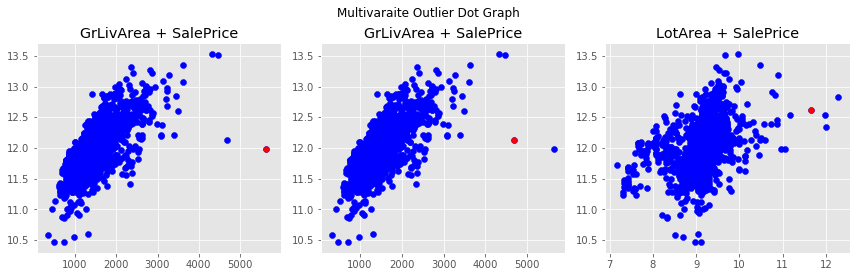

In [219]:
f, axes = plt.subplots(1,3, figsize = (12, 4))
f.suptitle('Multivaraite Outlier Dot Graph')
axes[0].scatter(df_train.loc[:,'GrLivArea'], df_train.loc[:, 'SalePrice'], c = 'b')
axes[0].scatter(df_train.ix[1298,'GrLivArea'], df_train.ix[1298, 'SalePrice'], c = 'r', s = 30)
axes[0].set_title('GrLivArea + SalePrice')
axes[1].scatter(df_train.loc[:,'GrLivArea'], df_train.loc[:, 'SalePrice'], c = 'b')
axes[1].scatter(df_train.ix[523,'GrLivArea'], df_train.ix[523, 'SalePrice'], c = 'r', s = 30)
axes[1].set_title('GrLivArea + SalePrice')
axes[2].scatter(df_train.loc[:,'LotArea'], df_train.loc[:, 'SalePrice'], c = 'b')
axes[2].scatter(df_train.ix[706,'LotArea'], df_train.ix[706, 'SalePrice'], c = 'r', s = 30)
axes[2].set_title('LotArea + SalePrice')
f.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

Pues definitivamente parecen outliers, entonces habrá que eliminarlos

In [220]:
df_train = df_train.drop(interOut.index)

 ### Codificación de variables

Primero vamos a codificar las variables que son ordinales. Antes de codificarlas, vamos a ver los valores únicos para cada columna y a partir de ahí decidimos qué valores le damos

In [221]:
for col in list(df_train[ordVar]):
    print(col)
    print(df_train[col].unique())

OverallQual
[ 7  6  8  5  9  4 10  3  1  2]
OverallCond
[5 8 6 7 4 2 3 9 1]
MSSubClass
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
ExterQual
['Gd' 'TA' 'Ex' 'Fa']
ExterCond
['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual
['Gd' 'TA' 'Ex' 'No' 'Fa']
BsmtCond
['TA' 'Gd' 'No' 'Fa' 'Po']
KitchenQual
['Gd' 'TA' 'Ex' 'Fa']
GarageQual
['TA' 'Fa' 'Gd' 'No' 'Ex' 'Po']
GarageCond
['TA' 'Fa' 'No' 'Gd' 'Po' 'Ex']
FireplaceQu
['No' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
HeatingQC
['Ex' 'Gd' 'TA' 'Fa' 'Po']
PoolQC
['No' 'Ex' 'Fa' 'Gd']


Como podemos ver, hay dos escalas básicas:

- `['Gd' 'TA' 'Ex' 'Fa']`
- `['TA' 'Gd' 'Fa' 'Po' 'Ex']`

Esas las podemos codoficar con una escala de valores común del 0 al 4 (y excluir el 0 para los que no tienen valor Po). 

También tenemos el caso en el que incluimos el valor 'No' para expresar que dicha casa carece de ese servicio, esto lo podemos codificar también como un cero, pero así estamos diciendo que, por ejemplo, no tener chimenea es peor que sí tenerla. No estoy del todo seguro de que ese sea el caso siempre (por ejemplo en las albercas). En todo caso como primera aproximación eso está bien.

In [231]:
df_train.loc[:,'ExterQual'] = df_train.loc[:,'ExterQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'ExterCond'] = df_train.loc[:,'ExterCond'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'BsmtQual'] = df_train.loc[:,'BsmtQual'].map({'No':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'BsmtCond'] = df_train.loc[:,'BsmtCond'].map({'No':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'KitchenQual'] = df_train.loc[:,'KitchenQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'GarageQual'] = df_train.loc[:,'GarageQual'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
df_train.loc[:,'GarageCond'] = df_train.loc[:,'GarageCond'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
df_train.loc[:,'FireplaceQu'] = df_train.loc[:,'FireplaceQu'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
df_train.loc[:,'HeatingQC'] = df_train.loc[:,'HeatingQC'].map({'Po':0,'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'PoolQC'] = df_train.loc[:,'PoolQC'].map({'No':0, 'Fa':1, 'Gd' : 2, 'Ex': 3})

Ahora vamos a aplicar _One Hot Encoding_ a las variables categóricas

In [223]:
df_cat = pd.get_dummies(df_train.loc[:, total_categoricas])
df_cat

,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,20,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,60,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,70,0,0,0,1,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,60,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1457,70,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


Ahora ya nada más nos falta juntar los dataframes, el original (ya procesado) y el dataframe con las categóricas ya codificadas. Por supuesto, también hay que quitar las categóricas originales

In [ ]:
df_train = pd.concat([df_train, df_cat], axis=1)
df_train.drop(total_categoricas, axis=1, inplace=True)
df_train

En principio ya deberíamos tener un dataframe con sólo variables numéricas ¿no?

In [229]:
df_train.columns.to_series().groupby(df_train.dtypes).groups

{dtype('uint8'): Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
        'MSZoning_RM', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
        'BldgType_Twnhs', 'BldgType_TwnhsE',
        ...
        'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
        'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
        'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
        'SaleCondition_Partial'],
       dtype='object', length=210),
 dtype('int64'): Index(['Id', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'PoolQC', 'MiscVal', 'M

Pues en efecto, ya sólo tenemos variables numéricas y podemos proceder entonces al [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering).

Antes conviene hacer dos cosas: exportar nuestros datos preprocesados como csv para reusarlos en otros notebooks y juntar todo el procesamiento en una celda para poder aplicarlo a los datos de prueba.

In [230]:
df_train.to_csv("data/train_preprocesado.csv")

Ahora podemos empacar todo el preproceso en una función para poder aplicarla diréctamente a la muestra de prueba. Obviamente la parte de detectar y eliminar outliers no entra en esta función (¿obviamente?)

In [273]:
def preprocesa_train(df):
    meaningfulNA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
    df[meaningfulNA] = df[meaningfulNA].fillna('No')
    
    df['SalePrice'] = np.log(df['SalePrice'])
        
    df['LotArea'] = np.log1p(df['LotArea'])
    dropNoCorr = ['BsmtFullBath', 'BsmtHalfBath','HalfBath', 'FullBath', 'KitchenAbvGr', 'GarageYrBlt']
    df.drop(dropNoCorr, axis=1, inplace=True)

    dfImpute = df.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea', 'MasVnrArea']].copy()
    testIx = dfImpute.loc[:,'MasVnrArea'].isnull()
    # train y test para la imputación
    dfTrain = dfImpute.loc[~testIx, :]
    dfTest = dfImpute.loc[testIx, :]
    # modelo de regresión
    lr = linear_model.LinearRegression()
    lr.fit(dfTrain.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']], dfTrain.loc[:, 'MasVnrArea'])
    lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']])
    # Asigno los valores calculados
    df.loc[testIx,'MasVnrArea'] = lrImpute

    dfImpute = df.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea','LotFrontage']].copy()
    testIx = dfImpute.loc[:,'LotFrontage'].isnull()
    # train y test para la imputación
    dfTrain = dfImpute.loc[~testIx, :]
    dfTest = dfImpute.loc[testIx, :]
    # modelo de regresión
    lr = linear_model.LinearRegression()
    lr.fit(dfTrain.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']], dfTrain.loc[:, 'LotFrontage'])
    lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']])
    # Asigno los valores calculados
    df.loc[testIx,'LotFrontage'] = lrImpute

    df.drop(['MasVnrType'], axis=1, inplace=True)

    df.loc[:,'ExterQual'] = df.loc[:,'ExterQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
    df.loc[:,'ExterCond'] = df.loc[:,'ExterCond'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
    df.loc[:,'BsmtQual'] = df.loc[:,'BsmtQual'].map({'No':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
    df.loc[:,'BsmtCond'] = df.loc[:,'BsmtCond'].map({'No':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
    df.loc[:,'KitchenQual'] = df.loc[:,'KitchenQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
    df.loc[:,'GarageQual'] = df.loc[:,'GarageQual'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
    df.loc[:,'GarageCond'] = df.loc[:,'GarageCond'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
    df.loc[:,'FireplaceQu'] = df.loc[:,'FireplaceQu'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
    df.loc[:,'HeatingQC'] = df.loc[:,'HeatingQC'].map({'Po':0,'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
    df.loc[:,'PoolQC'] = df.loc[:,'PoolQC'].map({'No':0, 'Fa':1, 'Gd' : 2, 'Ex': 3})

    df_cat = pd.get_dummies(df.loc[:, total_categoricas])

    df = pd.concat([df, df_cat], axis=1)
    df.drop(total_categoricas, axis=1, inplace=True)
    return df

In [237]:
procesado = preprocesa(df_train)
procesado.to_csv("data/train_preprocesado.csv")

## Preproceso de la muestra de prueba

Para poder probar las regresiones que hagamos más adelante, necesitamos también preprocesar la muestra de prueba. En principio el preproceso es el mismo, salvo dos cosas:

- El la muestra de prueba no podemos eliminar registros
- No sabemos si la muestra de prueba tiene valores faltantes en las mismas columnas

Esto quiere decir, primero, que no vamos a eliminar outliers en la muestra de prueba y, segundo, que es posible que tengamos que imputar otras variables.

La primera parte del proceso sí puede ser igual

In [449]:
df_test = pd.read_csv('data/test.csv')
meaningfulNA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
df_test[meaningfulNA] = df_test[meaningfulNA].fillna('No')
df_test['LotArea'] = np.log1p(df_test['LotArea'])
dropNoCorr = ['BsmtFullBath', 'BsmtHalfBath','HalfBath', 'FullBath', 'KitchenAbvGr', 'GarageYrBlt']
df_test.drop(dropNoCorr, axis=1, inplace=True)

Ahora vamos a ver en qué columnas tenemos valores faltantes

In [450]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,227,0.155586
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Utilities,2,0.001371
Functional,2,0.001371
BsmtFinSF2,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
GarageArea,1,0.000685


Las variables LotFrontage, MasVnrType y MasVnrArea también tienen faltantes en la muestra de entrenamiento, entonces ya sabemos cómo lidiar con ellas:

- MasVnrType la eliminamos 
- LotFrontage y MasVnrArea las imputamos con regresiones lineales

El problema es que para imputar MasVnrArea usamos GarageArea que en este caso también tiene un registro faltante, entonces necesitamos imputar ese primero. Vamos a ver sus correlaciones con las demás variables:

In [451]:
df_test.corr()['GarageArea'].sort_values(ascending=False).head()

GarageArea     1.000000
GarageCars     0.896674
OverallQual    0.568161
GrLivArea      0.504555
1stFlrSF       0.494192
Name: GarageArea, dtype: float64

Tomemos entonces sólo GarageCars y OverallQual para hacer la imputación. Pero GarageCars también tiene valores faltantes. Vamos a ver entonces si podemos imputar primero GarageCars

In [452]:
df_test.corr()['GarageCars'].sort_values(ascending=False).head()

GarageCars     1.000000
GarageArea     0.896674
OverallQual    0.600831
YearBuilt      0.538428
GrLivArea      0.515693
Name: GarageCars, dtype: float64

Aquí parece que podemos imputar muy bien usando OverallQual y  GrLivArea que no tienen valores faltantes!

In [453]:
dfImpute = df_test.loc[:, ['OverallQual', 'GrLivArea', 'GarageCars']].copy()
testIx = dfImpute.loc[:,'GarageCars'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['OverallQual', 'GrLivArea']], dfTrain.loc[:, 'GarageCars'])
lrImpute = lr.predict(dfTest.loc[:, ['OverallQual', 'GrLivArea']])
# Asigno los valores calculados
df_test.loc[testIx,'GarageCars'] = lrImpute
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,227,0.155586
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Utilities,2,0.001371
Functional,2,0.001371
BsmtFinSF2,1,0.000685
GarageArea,1,0.000685
SaleType,1,0.000685
BsmtUnfSF,1,0.000685


Ahora podemos imputar GarageArea

In [454]:
dfImpute = df_test.loc[:, ['GarageCars', 'OverallQual', 'GarageArea']].copy()
testIx = dfImpute.loc[:,'GarageArea'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['GarageCars', 'OverallQual']], dfTrain.loc[:, 'GarageArea'])
lrImpute = lr.predict(dfTest.loc[:, ['GarageCars', 'OverallQual']])
# Asigno los valores calculados
df_test.loc[testIx,'GarageArea'] = lrImpute
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,227,0.155586
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Functional,2,0.001371
Utilities,2,0.001371
BsmtFinSF2,1,0.000685
SaleType,1,0.000685
BsmtUnfSF,1,0.000685
TotalBsmtSF,1,0.000685


Ahora vamos con BsmtFinSF1

In [455]:
df_test.corr()['BsmtFinSF1'].sort_values(ascending=False).head()

BsmtFinSF1     1.000000
TotalBsmtSF    0.550444
1stFlrSF       0.470077
MasVnrArea     0.343267
Fireplaces     0.326075
Name: BsmtFinSF1, dtype: float64

Parece que necesitamos imputar primero TotalBsmtSF

In [456]:
df_test.corr()['TotalBsmtSF'].sort_values(ascending=False).head()

TotalBsmtSF    1.000000
1stFlrSF       0.784538
OverallQual    0.560314
BsmtFinSF1     0.550444
GarageArea     0.485573
Name: TotalBsmtSF, dtype: float64

Imputemos con 1stFlrSF y OverallQual

In [457]:
dfImpute = df_test.loc[:, ['1stFlrSF', 'OverallQual', 'TotalBsmtSF']].copy()
testIx = dfImpute.loc[:,'TotalBsmtSF'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'OverallQual']], dfTrain.loc[:, 'TotalBsmtSF'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'OverallQual']])
# Asigno los valores calculados
df_test.loc[testIx,'TotalBsmtSF'] = lrImpute
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,227,0.155586
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Utilities,2,0.001371
Functional,2,0.001371
BsmtUnfSF,1,0.000685
SaleType,1,0.000685
Exterior2nd,1,0.000685
Exterior1st,1,0.000685


Imputemos entonces, ahora sí, BsmtFinSF1

In [458]:
dfImpute = df_test.loc[:, ['TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1']].copy()
testIx = dfImpute.loc[:,'BsmtFinSF1'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['TotalBsmtSF', '1stFlrSF']], dfTrain.loc[:, 'BsmtFinSF1'])
lrImpute = lr.predict(dfTest.loc[:, ['TotalBsmtSF', '1stFlrSF']])
# Asigno los valores calculados
df_test.loc[testIx,'BsmtFinSF1'] = lrImpute
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
LotFrontage,227,0.155586
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Utilities,2,0.001371
Functional,2,0.001371
KitchenQual,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
BsmtFinSF2,1,0.000685


Imputemos entonces MasVnrArea como hicimos antes

In [459]:
dfImpute = df_test.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea', 'MasVnrArea']].copy()
testIx = dfImpute.loc[:,'MasVnrArea'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']], dfTrain.loc[:, 'MasVnrArea'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']])
# Asigno los valores calculados
df_test.loc[testIx,'MasVnrArea'] = lrImpute

Y entonces podemos ir con LotFrontage

In [460]:
dfImpute = df_test.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea','LotFrontage']].copy()
testIx = dfImpute.loc[:,'LotFrontage'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']], dfTrain.loc[:, 'LotFrontage'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']])
# Asigno los valores calculados
df_test.loc[testIx,'LotFrontage'] = lrImpute

Vamos rápido a ver en qué vamos

In [461]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
MasVnrType,16,0.010966
MSZoning,4,0.002742
Utilities,2,0.001371
Functional,2,0.001371
KitchenQual,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
BsmtFinSF2,1,0.000685
BsmtUnfSF,1,0.000685
SaleType,1,0.000685


Ok, vamos a encargarnos de MasVnrType de una vez

In [462]:
df_test.drop(['MasVnrType'], axis=1, inplace=True)

Bien ahora ya sólo nos queda imputar MSZoning, Utilities, Functional, KitchenQual, Exterior1st, Exterior1st, Exterior1st, Exterior2nd, BsmtFinSF2 y BsmtUnfSF. BsmtFinSF2 y BsmtUnfSF son numéricas, esas las podemos imputar con el método que ya sabemos

In [463]:
df_test.corr()['BsmtFinSF2'].sort_values(ascending=False).head(10)

BsmtFinSF2     1.000000
WoodDeckSF     0.126032
Fireplaces     0.083655
TotalBsmtSF    0.076092
1stFlrSF       0.073346
LotArea        0.072326
LotFrontage    0.057931
PoolArea       0.050152
OverallCond    0.043109
ScreenPorch    0.039806
Name: BsmtFinSF2, dtype: float64

Bueno, aquí si vamos a tener un problema, porque no se correlaciona muy bien con nada. Afortunadamente es sólo un valor!

In [464]:
dfImpute = df_test.loc[:, ['WoodDeckSF', 'Fireplaces', 'TotalBsmtSF','BsmtFinSF2']].copy()
testIx = dfImpute.loc[:,'BsmtFinSF2'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['WoodDeckSF', 'Fireplaces', 'TotalBsmtSF']], dfTrain.loc[:, 'BsmtFinSF2'])
lrImpute = lr.predict(dfTest.loc[:, ['WoodDeckSF', 'Fireplaces', 'TotalBsmtSF']])
# Asigno los valores calculados
df_test.loc[testIx,'BsmtFinSF2'] = lrImpute

Lo mismo pero para BsmtUnfSF

In [465]:
df_test.corr()['BsmtUnfSF'].sort_values(ascending=False).head(10)

BsmtUnfSF       1.000000
TotalBsmtSF     0.409023
1stFlrSF        0.275569
TotRmsAbvGrd    0.243566
OverallQual     0.243070
GrLivArea       0.226780
BedroomAbvGr    0.199661
YearRemodAdd    0.148773
GarageCars      0.147048
GarageArea      0.145673
Name: BsmtUnfSF, dtype: float64

In [466]:
dfImpute = df_test.loc[:, ['TotalBsmtSF', '1stFlrSF','BsmtUnfSF']].copy()
testIx = dfImpute.loc[:,'BsmtUnfSF'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['TotalBsmtSF', '1stFlrSF']], dfTrain.loc[:, 'BsmtUnfSF'])
lrImpute = lr.predict(dfTest.loc[:, ['TotalBsmtSF', '1stFlrSF']])
# Asigno los valores calculados
df_test.loc[testIx,'BsmtUnfSF'] = lrImpute

Ahora ya sólo nos falta imputar variables categóricas

In [467]:
df_test[['MSZoning', 'Utilities', 'Functional', 'KitchenQual', 'Exterior1st', 'Exterior1st', 
 'Exterior1st', 'Exterior2nd', 'BsmtFinSF2', 'BsmtUnfSF']].head()

,MSZoning,Utilities,Functional,KitchenQual,Exterior1st,Exterior1st,Exterior1st,Exterior2nd,BsmtFinSF2,BsmtUnfSF
0,RH,AllPub,Typ,TA,VinylSd,VinylSd,VinylSd,VinylSd,144.0,270.0
1,RL,AllPub,Typ,Gd,Wd Sdng,Wd Sdng,Wd Sdng,Wd Sdng,0.0,406.0
2,RL,AllPub,Typ,TA,VinylSd,VinylSd,VinylSd,VinylSd,0.0,137.0
3,RL,AllPub,Typ,Gd,VinylSd,VinylSd,VinylSd,VinylSd,0.0,324.0
4,RL,AllPub,Typ,Gd,HdBoard,HdBoard,HdBoard,HdBoard,0.0,1017.0


Utilicemos el valor más frecuente ed cada volumna para hacer la imputación.

In [468]:
cat_cols = ['MSZoning', 'Utilities', 'Functional', 'KitchenQual', 'Exterior1st', 'Exterior1st', 'Exterior1st', 'Exterior2nd','SaleType']
relleno = pd.Series(dict([(c, df_test[c].value_counts().index[0]) for c in cat_cols]))
relleno

MSZoning            RL
Utilities       AllPub
Functional         Typ
KitchenQual         TA
Exterior1st    VinylSd
Exterior2nd    VinylSd
SaleType            WD
dtype: object

In [469]:
df_test['MSZoning'].fillna('RL', inplace=True)
df_test['Utilities'].fillna('AllPub', inplace=True)
df_test['Functional'].fillna('Typ', inplace=True)
df_test['KitchenQual'].fillna('TA', inplace=True)
df_test['Exterior1st'].fillna('VinylSd', inplace=True)
df_test['Exterior2nd'].fillna('VinylSd', inplace=True)
df_test['SaleType'].fillna('WD', inplace=True)

total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
SaleCondition,0,0.0
BsmtFinSF2,0,0.0
YearBuilt,0,0.0
YearRemodAdd,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0


Ahora ya sólo nos hace falta codificar todas las variables com la muestra de entrenamiento.

In [471]:
df_test.loc[:,'ExterQual'] = df_test.loc[:,'ExterQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_test.loc[:,'ExterCond'] = df_test.loc[:,'ExterCond'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_test.loc[:,'BsmtQual'] = df_test.loc[:,'BsmtQual'].map({'No':0, 'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_test.loc[:,'BsmtCond'] = df_test.loc[:,'BsmtCond'].map({'No':0, 'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
df_test.loc[:,'KitchenQual'] = df_test.loc[:,'KitchenQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_test.loc[:,'GarageQual'] = df_test.loc[:,'GarageQual'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
df_test.loc[:,'GarageCond'] = df_test.loc[:,'GarageCond'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
df_test.loc[:,'FireplaceQu'] = df_test.loc[:,'FireplaceQu'].map({'No':0,'Po':1,'Fa':2, 'TA':3, 'Gd' : 4, 'Ex': 5})
df_test.loc[:,'HeatingQC'] = df_test.loc[:,'HeatingQC'].map({'Po':0,'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_test.loc[:,'PoolQC'] = df_test.loc[:,'PoolQC'].map({'No':0, 'Fa':1, 'Gd' : 2, 'Ex': 3})

df_cat = pd.get_dummies(df_test.loc[:, total_categoricas])

df_test = pd.concat([df_test, df_cat], axis=1)
df_test.drop(total_categoricas, axis=1, inplace=True)

Antes de exportar, necesitamos ver que tengan las mismas columnas. Podría ser que no si en la muestra de entrenamiento (o en la de prueba) hay valores categóricos que no aparecen en la otra.

In [483]:
set(df_train.columns).difference(df_test.columns)

{'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'MiscFeature_TenC',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'SalePrice',
 'Utilities_NoSeWa'}

Entonces, hay que crear esas columnas en los datos de prueba y llenarlas con 0

In [ ]:
missing_cols = list(set(df_train.columns).difference(df_test.columns))
missing_cols.remove('SalePrice')
for c in missing_cols:
    df_test[c] = 0

Y ahora sí, lo exportamos

In [493]:
df_test.head()

,Unnamed: 0,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Exterior2nd_Other,Condition2_RRNn,Exterior1st_Stone,Utilities_NoSeWa,Heating_OthW,Exterior1st_ImStucc,RoofMatl_ClyTile,Electrical_Mix,HouseStyle_2.5Fin,RoofMatl_Membran
0,0,1461,80.0,9.360741,5,6,1961,1961,0.0,2,...,0,0,0,0,0,0,0,0,0,0
1,1,1462,81.0,9.565775,6,6,1958,1958,108.0,2,...,0,0,0,0,0,0,0,0,0,0
2,2,1463,74.0,9.534668,5,5,1997,1998,0.0,2,...,0,0,0,0,0,0,0,0,0,0
3,3,1464,78.0,9.208238,6,6,1998,1998,20.0,2,...,0,0,0,0,0,0,0,0,0,0
4,4,1465,43.0,8.518392,8,5,1992,1992,0.0,3,...,0,0,0,0,0,0,0,0,0,0


In [497]:
#df_test.drop(['Unnamed: 0'], axis=1, inplace=True)
#df_test.set_index('Id', inplace=True)
#df_test
df_test.to_csv("data/test_preprocesado.csv")